In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

/Users/kirillsobolev/Documents/GitHub/ML_project/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the dataset
df = pd.read_csv('../ready_data/merged_marwis.csv')
# Rename time dimension to "ds" and target variable to "y". This is COMPULSORY
df.rename({"timestamp": "ds",
           "Friction": "y"}, axis=1, inplace=True, copy=False)
df["ds"] = pd.to_datetime(df["ds"])
df['ds'] = df['ds'].dt.tz_localize(None)

df

,ds,Amb_T,y,Dew_Point_T,RH_at_Road_T,Water_Film_mm,Ice_Percentage,Road_Condition,Water_Film_Surface_mm,Road_Surface_Temperature
0,2023-12-01 06:00:00,7.542445,0.770759,0.0,85.157728,0.291341,0.000000,2.000000,0.100736,6.070967
1,2023-12-01 06:05:00,6.358008,0.627356,0.0,94.090596,0.307111,41.559838,2.855705,0.108008,1.225372
2,2023-12-01 06:10:00,1.043127,0.735368,0.0,100.000000,0.110350,36.588811,2.909091,0.043079,-2.701785
3,2023-12-01 06:15:00,1.000389,0.533147,0.0,100.000000,0.341481,69.512639,3.000000,0.120704,-2.368484
4,2023-12-01 06:20:00,1.000971,0.656794,0.0,100.000000,0.195085,53.043867,2.809365,0.070209,-2.343937
...,...,...,...,...,...,...,...,...,...,...
7617,2024-02-29 13:05:00,12.465430,0.812769,0.0,62.248380,0.020946,0.000000,0.000000,0.013573,15.102599
7618,2024-02-29 13:10:00,13.078210,0.813238,0.0,63.752008,0.019117,0.000000,0.000000,0.012682,15.284287
7619,2024-02-29 13:15:00,13.555827,0.813537,0.0,64.891077,0.017985,0.000000,0.000000,0.012114,15.431717
7620,2024-02-29 13:20:00,13.936328,0.809958,0.0,65.357731,0.042180,0.000000,0.288591,0.019243,15.438219


In [3]:
# Take a sample from dataset to cut off edges where friction is almost 0.8 every time
df["cap"] = 0.82

In [4]:
# Split the data to train and test
cutoff = int(len(df) * 0.8)

# train data
X_train = df[0:cutoff]
# test data 
X_test = df[cutoff:]

In [5]:
df.columns

Index(['ds', 'Amb_T', 'y', 'Dew_Point_T', 'RH_at_Road_T', 'Water_Film_mm',
       'Ice_Percentage', 'Road_Condition', 'Water_Film_Surface_mm',
       'Road_Surface_Temperature', 'cap'],
      dtype='object')

In [6]:
# Initialaze forecaster and scale values
model = Prophet(growth="logistic", scaling="minmax")
# Add regressors for multivariativity. Add a new regressor for each variable in dataset
model.add_regressor("Amb_T", standardize=False)
model.add_regressor("Dew_Point_T", standardize=False)
model.add_regressor("RH_at_Road_T", standardize=False)
model.add_regressor("Water_Film_mm", standardize=False)
model.add_regressor("Ice_Percentage", standardize=False)
model.add_regressor("Road_Condition", standardize=False)
model.add_regressor("Water_Film_Surface_mm", standardize=False)
model.add_regressor("Road_Surface_Temperature", standardize=False)

# Fit the model
model.fit(X_train)

10:33:15 - cmdstanpy - INFO - Chain [1] start processing
10:33:18 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# Delete y variable from dataset
X_train2 = X_train.drop("y",axis=1)
X_test2 = X_test.drop("y", axis=1)

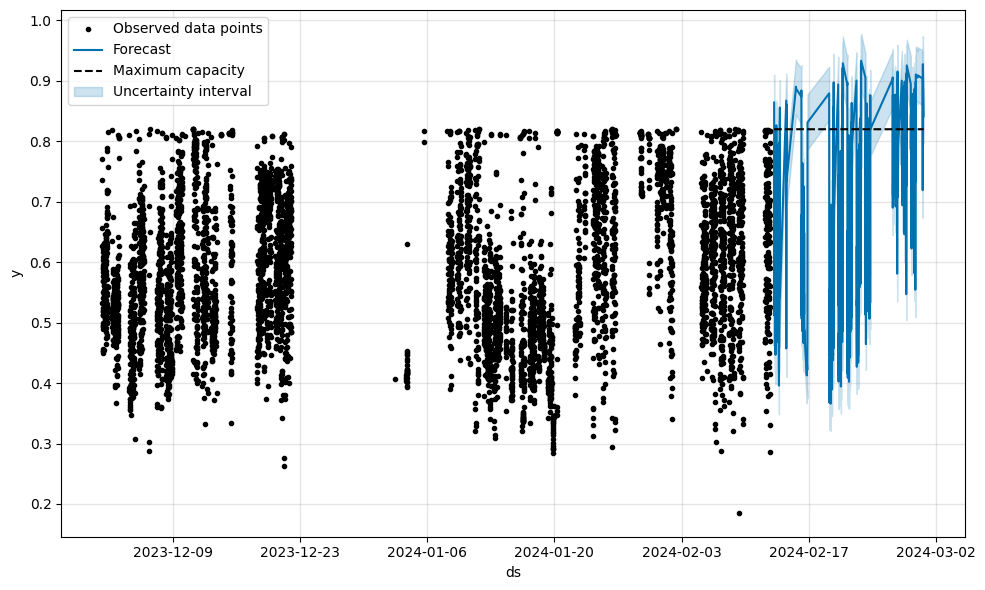

In [8]:
# Make a forecast for unseen X_test data and plot forecast
fcst = model.predict(X_test2)
fig = model.plot(fcst, include_legend=True)

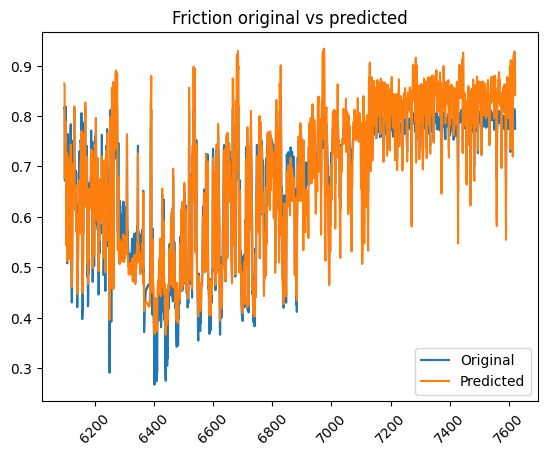

In [9]:
plt.title('Friction original vs predicted')
plt.plot(X_test.index, X_test.y, label="Original")
plt.plot(X_test.index, fcst.yhat, label="Predicted")
plt.xticks(rotation=45)
plt.legend()
